<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Classification of  Subreddit Data with NLP 


## Objectives of the Project

The project aimed to build classification models that used to  correctly classify the subreddit topics based on submitted subreddit with best accuracy.

### Contents:
- [Data Collection (Separate Notebooks)](#Data-Collection-(-Separate-Notebooks)
    - [Import Packages](#Import-Packages)
 
- [Cleaning and EDA](#Data-Loading-and-Cleaning)
    - [Concatenating Data into Combined Data Frame](#Concatenating-Data-into-Combined-Data-Frame)
    - [Clean Data and Removed Stopwords](#Clean-Data-and-Removed-Stopwords)
    - [EDA of the Raw Data](#EDA-of-the-Raw-Data)
    
- [Preprocessing](#Preprocessing)
    - [Train Test Split](#Train-Test-Split)
    - [Vectorized the Cleaned Data](#Vectorized-the-Cleaned-Data)
    
- [Modeling and Evaluation](#Modeling-and-Evaluation)
    - [Determining Baseline Score](#Determining-Baseline-Score)
    - [Construct Grid Search  and Confusion Matrix for the Models](#PConstruct-Grid-Search-and-Confusion-Matrix-for-the-Models)
    - [Evaluate Models](#Evaluate-Models)

- [Best Performed Modeled](#Best-Performed-Modeled)
    - [Summary Statistics](#Summary-Statistics)
    - [Common words Count](#Common-words-Count)
    - [Receiver Operating Characteristic(ROC)](#Receiver-Operating-Characteristic(ROC))
    
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

### Import Packages

In [1]:
# Load basic libraries
import pandas as pd
import numpy as np
import requests
import time
import random

# Load text processing and cleaning libraries
import regex as re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from pprint import pprint
from collections import Counter
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Load proprocessing/modeling/evaluation libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

# Load visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from os import path


## Data Loading and Cleaning

Publicly available submissions on Reddit data of subreddits r/datascience and r/math were loaded to the notebook for further cleaning the documents to make the text data ready for modeling.

In [2]:
# Default storpwords, words vectorizer and customized stoped words
stops = set(stopwords.words('english')) 
cvec = CountVectorizer(stop_words='english')

customize_stops={'math','datascience','lt','z','remov','e','anyon',
                 'u','would','ac','like','use','n','scienc','help','x','b','r',
                 'gt','f','datar'}
yy = customize_stops # assigned the customized word

---

## Load the data

- Get subreddit data from local drive.

In [3]:
# Read the csv files of the subreddits math and datascience
df_ds = pd.read_csv('data/datascience.csv')  # datascience subreddit
df_math = pd.read_csv('data/math.csv') # math subreddit
df = pd.concat([df_ds, df_math]) # Combined the two DataFrames

In [4]:
# Drop the unnamed columns
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
df.head(3)

,title,author,created_utc,selftext,subreddit
0,The Online Data That's Being Deleted,arminham1967,1627232620,NaN,datascience
1,Data Engineering using Databricks course.,VamsiPenmetsa77,1627229122,[removed],datascience
2,New Technology Opens the Gate to the Next Gene...,Perfect_Antelope_,1627228512,NaN,datascience


In [5]:
# To check data type and missed values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18400 entries, 0 to 9199
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        18400 non-null  object
 1   author       18400 non-null  object
 2   created_utc  18400 non-null  int64 
 3   selftext     14107 non-null  object
 4   subreddit    18400 non-null  object
dtypes: int64(1), object(4)
memory usage: 862.5+ KB


In [6]:
# look the missed values
df.isnull().sum().sort_values(ascending=False).head(30)

selftext       4293
title             0
author            0
created_utc       0
subreddit         0
dtype: int64

#### Clean Scraped Dataset 

In [7]:
def utilityFuction(raw_text, customize_stops:{}):

    text = re.sub(r'http[s]{0,1}://[^\s]*', '', raw_text) # Strip urls and special char
    letters = re.sub("[^a-zA-Z]", " ", text) # Remove non-letters
    words = letters.lower().split() # Convert to lower case, split to individual words      
    relevantWords = [w for w in words if w not in stops]  
    stops.update(yy) # Add customize stopwords
       
    return (" ".join(relevantWords))
# Patally the function idea taken from lesson 5.02

In [8]:
# Fill the missed values by space 
df = df.replace(np.nan, '', regex=True) # All dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18400 entries, 0 to 9199
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        18400 non-null  object
 1   author       18400 non-null  object
 2   created_utc  18400 non-null  int64 
 3   selftext     18400 non-null  object
 4   subreddit    18400 non-null  object
dtypes: int64(1), object(4)
memory usage: 862.5+ KB


In [9]:
# Cleaning the main text in the columns using utility function
df['title_clean']=df['title'].apply(lambda x:utilityFuction(x, yy)) # cleaned the text and put it to new column
df['author_clean']=df['author'].apply(lambda x:utilityFuction(x, yy))
df['selftext_clean']=df['selftext'].apply(lambda x:utilityFuction(x, yy) if x is not None else x)

In [10]:
# Check the missed values removed
df[df['selftext'].isnull()]['selftext']

Series([], Name: selftext, dtype: object)

In [11]:
# Check the cleaned text in the cleaned columns
df.head(2)

,title,author,created_utc,selftext,subreddit,title_clean,author_clean,selftext_clean
0,The Online Data That's Being Deleted,arminham1967,1627232620,,datascience,online data deleted,arminham,
1,Data Engineering using Databricks course.,VamsiPenmetsa77,1627229122,[removed],datascience,data engineering using databricks course,vamsipenmetsa,removed


In [12]:
# Removed unclean columns
df = df.drop(['title','author', 'selftext', 'created_utc'], axis = 1)

In [13]:
#Look the culumns removed from the DataFrames
df.head(2)

,subreddit,title_clean,author_clean,selftext_clean
0,datascience,online data deleted,arminham,
1,datascience,data engineering using databricks course,vamsipenmetsa,removed


In [14]:
# Combined the cleaned selftext and title columns to a column
df['title_selftextCombin'] = df['selftext_clean']+' '+df['title_clean']
df['title_selftextCombin'] = df['title_selftextCombin'].apply(lambda x: x.strip())
df.head(2)

,subreddit,title_clean,author_clean,selftext_clean,title_selftextCombin
0,datascience,online data deleted,arminham,,online data deleted
1,datascience,data engineering using databricks course,vamsipenmetsa,removed,removed data engineering using databricks course


In [15]:
# words in the 'title_clean' column before joining
df['title_clean'][0].values[0]

'online data deleted'

In [16]:
# Function to count words
def countWords(df):
    
    # Count Vectorize
    cvec = CountVectorizer(stop_words = 'english')

    # Transform the corpus
    text = cvec.fit_transform(df['title'])

    # Converts text to array form
    text = pd.DataFrame(text.toarray(), columns= cvec.get_feature_names())

    # See word counts
    countWords = text.sum().sort_values(0, ascending=False)
    
    return countWords

In [17]:
# Calling the function to look the r/datascience  
countWords(df_ds)

data         4363
science      2241
learning      514
job           454
scientist     445
             ... 
gestures        1
peak            1
gephy           1
penalty         1
𝟏𝟎𝟎             1
Length: 7815, dtype: int64

In [18]:
#Calling the function to look the r/math 
countWords(df_math)

math            1419
help            1199
question         561
need             454
problem          366
                ... 
impulse            1
improvements       1
improper           1
impromptu          1
li                 1
Length: 8828, dtype: int64

### EDA of the Data

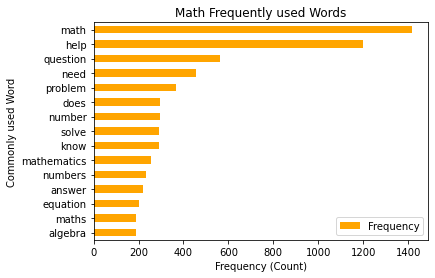

In [19]:
# Graph for r/math Frequently used words
math_wordcount= pd.DataFrame(countWords(df_math), columns=["Frequency"])

# Visualize
math_top_15 = math_wordcount.head(15)
math_top_15.sort_values('Frequency',ascending=True).plot(kind = "barh", color='orange')
plt.title("Math Frequently used Words")
plt.xlabel("Frequency (Count)")
plt.ylabel("Commonly used Word")
plt.show()

In [20]:
#Total of frequented words
math_wordcount.sum()

Frequency    48231
dtype: int64

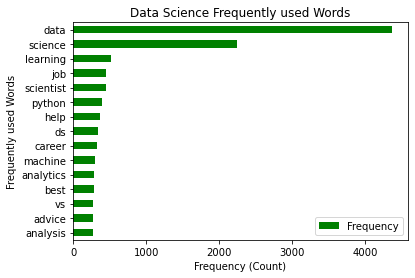

In [21]:
# Graph for r/datascience frequently used words  
datascience_wordcount = pd.DataFrame(countWords(df_ds), columns=["Frequency"])

# Visualize
datascience_top15 = datascience_wordcount.head(15)
datascience_top15.sort_values('Frequency',ascending=True).plot(kind = "barh", color='green')
plt.title("Data Science Frequently used Words")
plt.xlabel("Frequency (Count)")
plt.ylabel("Frequently used Words")
plt.show()

In [22]:
#Total of frequented words
datascience_wordcount.sum()

Frequency    55209
dtype: int64

In [23]:
# words in the 'selftext_clean' column before joining
df['selftext_clean'][0]

0                                                     
0    ago purchased straighterline calculus course u...
Name: selftext_clean, dtype: object

In [24]:
# Content of the combined clean columns of 'title_clean' and 'selftext_clean'
df['title_selftextCombin'][0].values[0]

'online data deleted'

In [25]:
# SHape of the DataFrame
df.shape

(18400, 5)

In [26]:
# Check the first two rows of the DataFrames of math and datascience subreddit
df.head(2)

,subreddit,title_clean,author_clean,selftext_clean,title_selftextCombin
0,datascience,online data deleted,arminham,,online data deleted
1,datascience,data engineering using databricks course,vamsipenmetsa,removed,removed data engineering using databricks course


In [27]:
# Check the last two rows of the DataFrames of math and datascience subreddit
df.tail(2)

,subreddit,title_clean,author_clean,selftext_clean,title_selftextCombin
9198,math,total loss calculus,sukesada,removed,removed total loss calculus
9199,math,hey th grader confused teaching area parallelo...,thephoenixmage,,hey th grader confused teaching area parallelo...


In [28]:
# Describe the combined and cleaned dataframe
df.describe()

,subreddit,title_clean,author_clean,selftext_clean,title_selftextCombin
count,18400,18400,18400,18400,18400
unique,2,16956,13149,8452,17409
top,datascience,,deleted,removed,
freq,9200,255,262,5191,143


### Preprocessing

This part addressed calculating the baseline of the data and assigning the model variables. Train Test Split was carried to evaluate the vectorized data for the model evaluation.

In [29]:
# Checking the baseline.  
df['subreddit'].value_counts(normalize=True)

datascience    0.5
math           0.5
Name: subreddit, dtype: float64

In [30]:
# Assigning variables of the subreddit to make modeling
X = df['title_selftextCombin']
y = df['subreddit']

-*Note*:
 
 - The baseline shows the sample is balanced to make  modeling. That means the predict belongs to the `math` subreddit as the order of the data. Therefore, the baseline accuracy is for both datascience and math is **50%**.

## Modeling and Evaluation

Defined the different models' pipeline parameters for the evaluation of the cleaned and vectorized data.

In [31]:
# Fuction to perform modelling. The code adapted from DSI-614 week4 to week6 classes
# https://stackoverflow.com and # Hands on data science and Python machine learning by Frank Kane

def classify(X, y, model='lr'):
    
    # Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)
    models = {
        'lr': LogisticRegression(solver='lbfgs'),
        'knn': KNeighborsClassifier(),
        'nb': MultinomialNB(),
        'rf': RandomForestClassifier(),
        'et': ExtraTreesClassifier(),
    }
    
    # Creating a pipeline with wordvectore and transforms text to feature vectors
    # to use as input for the pipeline 
    pipeline = Pipeline([
        ('cvec', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        (model, models[model])
    ])
    
    
    # Setting pipeline hyperparameters 
    parameters = {
        'cvec__max_df': [0.3, 0.6], # Maximum number of words to include above between 30% &60%
        'cvec__max_features': [2500, 5000, 10000], # Maximum number of features fit the given values
        'cvec__ngram_range': [(1, 1), (1, 2),(1, 3)],  # Check unigrams or bigrams
        'tfidf__use_idf': [True, False]
    }
    
    # Additional parameters for the different models
    if model == 'lr':
        parameters.update({'lr__penalty': ('none','l2')})
    elif model == 'knn':
        parameters.update({
            'knn__n_neighbors':[3,5,11],
            'knn__weights':['uniform','distance'],
        })
    elif model == 'nb':
        parameters.update({'nb__alpha':(1,2)})
    
    elif model == 'rf':
        parameters.update({
            'rf__n_estimators': [100,150],
            'rf__max_depth': [1,2,None]
        })
    elif model == 'et':
        parameters.update({
            'et__n_estimators': [50,100,150]
        })
   

    # Grid search evaluation  with some default values
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Grid search Performance")
    print("Pipeline:", [name for name, _ in pipeline.steps])
    print("Parameters:")
   
    grid_search.fit(X_train, y_train)
    
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
    
    # Model with best parameters in the train set
    pipeline_final = Pipeline([
        ('cvec', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        (model, models[model])
    ])
    pipeline_final.set_params(**grid_search.best_params_)
    final_model = pipeline.fit(X_train,y_train)
    print('Final model score')
  

    print(f'Train score: {final_model.score(X_train,y_train)}') 
    print(f'Test score: {final_model.score(X_test,y_test)}')
    
    predictions = final_model.predict(X_test)

   # Confusion_matrix of calculated based on y_test and predicted value
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
   
    print("True Positives: %s" % tp)
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    
    
    return X_test,y_test, final_model.predict(X_test)

- Evaluate the classify function that can be used as an input of all models function to find the best grid search hyperparameters and confusion matrix.

In [32]:
# To develope a link beteween the classify fuctions and all_models 
def all_models(X,y):
    models = {
    'lr': 'Logistic Regresson',
    'knn': 'K Nearest Neighbours',
    'nb': 'Naive Bayes',
    'rf': 'Random Forest',
    'et': 'Extra Trees',    
    }

    predModel= {m:None for m in models}
    
    for model in models:
        print(f'----------------- {models[model]} ------------------')
        predModel['text'],predModel['label'],predModel[model] = classify(X, y, model=model)
      

    cols = ['text','lr','knn','nb','rf','et','label']
    model_df = pd.DataFrame(predModel)[cols]

    return model_df

# Adoped ideas were taken from the books:
# Python for Data Analysis by McKinney
# Hands on data science and Python machine learning by Frank Kane

#### Evaluate Models 
- The evaluation used all possible outcomes of the models’  to screen the best performanced one. The models classification capacities were investigated  based on the score values without underfit and overfit natures of the train and test score accuracies as well as confusion matrix.

In [33]:
df_val = all_models(X ,y)

----------------- Logistic Regresson ------------------
Grid search Performance
Pipeline: ['cvec', 'tfidf', 'lr']
Parameters:
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best score: 0.928
Best parameters set:
	cvec__max_df: 0.6
	cvec__max_features: 5000
	cvec__ngram_range: (1, 3)
	lr__penalty: 'l2'
	tfidf__use_idf: True
Final model score
Train score: 0.9555072463768116
Test score: 0.9323913043478261
True Positives: 2227
True Negatives: 2062
False Positives: 238
False Negatives: 73
----------------- K Nearest Neighbours ------------------
Grid search Performance
Pipeline: ['cvec', 'tfidf', 'knn']
Parameters:
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best score: 0.726
Best parameters set:
	cvec__max_df: 0.6
	cvec__max_features: 2500
	cvec__ngram_range: (1, 2)
	knn__n_neighbors: 3
	knn__weights: 'distance'
	tfidf__use_idf: False
Final model score
Train score: 0.9981884057971014
Test score: 0.5641304347826087
True Positives: 2275
True Negatives: 320


### Evaluation of  Models 

 - Comparing results over a different models

In [34]:
models = {
    'lr': 'Logistic Regresson',
    'knn': 'K Nearest Neighbours',
    'nb': 'Naive Bayes',
    'rf': 'Random Forest',
    'et': 'Extra Trees',
    }
models_list = [m for m in models]

In [35]:
# Accuracy of the models
model_scores = {model: len(df_val[df_val[model] == df_val['label']]) 
                / len(df_val) for model in models}
model_scores

{'lr': 0.9323913043478261,
 'knn': 0.5641304347826087,
 'nb': 0.915,
 'rf': 0.9243478260869565,
 'et': 0.9269565217391305}

*Note*:
- The Logistic Regression did better accuracy than the rest of all the models with closer values of Training and Testing, accuracy scores with 2.5% difference between the scores. On the contrary, the KNN performed very low accuracy with a high degree of overfitting about 43% difference between train and test scores accuracy. The Logistic Regression was used for the rest of the analysis to see how many values were correctly/incorrectly predicted using a confusion matrix and further explanations of the classification.

In [36]:
#Summary Statistics of modeled dataframe
df_val.describe()

,text,lr,knn,nb,rf,et,label
count,4600,4600,4600,4600,4600,4600,4600
unique,4462,2,2,2,2,2,2
top,removed,math,math,datascience,math,datascience,math
freq,24,2465,4255,2527,2358,2328,2300


## Misclassified words

In [37]:
## False Positive
# Post that are suppose to be in r/datascience but classified as r/math
ds_index_misclass = df_val[(df_val['lr'] == 'math') & (df_val['label'] == 'datascience')].index 

# False Negative
# Post that are suppose to be in r/math but classified as in r/datasciience
ma_index_misclass = df_val[(df_val['lr'] == 'datascience') & (df_val['label'] == 'math')].index 


<AxesSubplot:ylabel='10 most common misclassified ds words'>

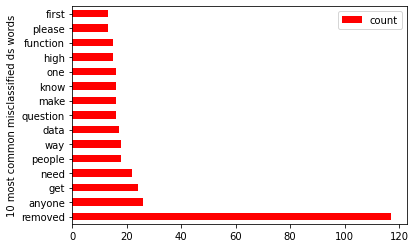

In [38]:
pd.DataFrame(Counter(' '.join([df[df.index==i]['title_selftextCombin'].values[0] for i in ds_index_misclass])
                     .split()).most_common()).head(15).set_index(0).rename(columns={1:'count'}).plot(kind='barh',color='red', xlabel='10 most common misclassified ds words')

#### Post that are suppose to be in math but are classified as datascience

<AxesSubplot:ylabel='10 most common misclassified ma words'>

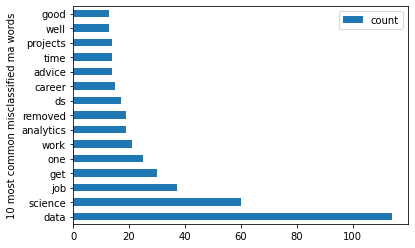

In [39]:
pd.DataFrame(Counter(' '.join([df[df.index==i]['title_selftextCombin'].values[0] for i in ma_index_misclass])
                     .split()).most_common()).head(15).set_index(0).rename(columns={1:'count'}).plot(kind='barh', xlabel='10 most common misclassified ma words')

Area under the Receiver Operating Characteristic curve: 0.932391304347826


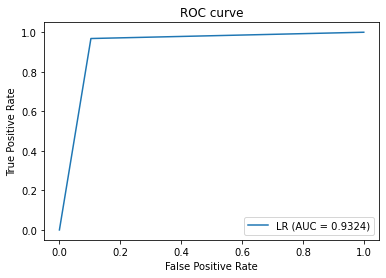

In [40]:
# Area under the Receiver Operating Characteristic curve 
df_val['label_1']=np.where(df_val['label']=='math',1,0)
df_val['lr_1']=np.where(df_val['lr']=='math',1,0)
fpr, tpr, thresholds = roc_curve(df_val['label_1'], df_val['lr_1'])
plt.plot(fpr, tpr, label="LR (AUC = 0.9324)", linestyle="-")
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc_score(df_val['label_1'], df_val['lr_1']))
# add a legend
plt.legend();

 *Note*:
- The AUC of logistic regression shows 93% performance in distinguishing the classified subreddits correctively under their classes. 

## Conclusion and Recommendations


Different models were used to evaluate the best classification of the subreddit math and data science with a baseline accuracy of 50%. All the model results performed at least 40% greater than the baseline with accuracy values of above 91%, except KNN which performed with lower accuracy of about 56%. The results demonstrated a strong ability to classify more than  4 in 5 posts into the correct subreddit. However, the clear winner was the logistic regression(LR) model, which was able to correctly classify 4 in 5 posts. Therefore, the results suggested to Reddit administrators to use the LR model to help them to classify the posts under their subreddit.  The second-best performing model is ExtraTreesClassifier with little overfitting behaviour. Naive Bayes model with a data size of 26000 having accuracy values of 92% with little overfitting about 2.56% difference of the scores and lower values of sensitivity (0.88) to predict maths from the actual. In conclusion, the Reddit administrator needs to be aware of some misclassified categories of the subreddits. The company may need to use other alternative methods to control such misclassified posts since the nature of the posts are very dynamic based on time and the situation to create wrong classification.